# MXNet with Keras

MXNet can be up to 2.5x faster than Google Tensorflow 2. Check [performance comparison](https://medium.com/@mouryarishik/tensorflow-2-0-vs-mxnet-41edd3b7574f):
* MXNet-Gluon   can be 1.8 times faster than Tensorflow.
* MXNet-Module  can be 2.5 times faster that Tensorflow.

MXNet can also be used with Keras as as high level api using an AWS Labs [library](https://github.com/awslabs/keras-apache-mxnet).

In this notebook we will test MXNet using Kearas as a high level api for its simplicity during the research phase of a project.


### Modelling Artificial Neural Networks
Check the full intruduciton [here](https://towardsdatascience.com/applied-deep-learning-part-1-artificial-neural-networks-d7834f67a4f6). 
While building a deep neural network we will add several Dense layers one after another. The output of one layer becomes the input of the next. Keras again does most of the heavylifting of initializing the weights and biases, and connecting the output of one layer to the input of the next. We only need to specify how many nodes we want in that layer, and the activation function. 

Step 1: Define a Sequantial model.</p>
Step 2: Add a number of Dense layers with their appropriate activation functions.
Step 3: Compile the model with an optimizer and loss function.</p>
Step 4: Fit the model to the dataset.</p>
Step 5: Analyze the results: plotting loss/accuracy curves, plotting the decision boundary, looking at the classification report, and understanding the confusion matrix.

In [23]:
from __future__ import print_function
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

import keras
import sklearn
import quantstats as qs

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

qs.extend_pandas()

from datetime import datetime
from matplotlib.colors import ListedColormap


## Utility Functions

These are the plotting helper functions used further down in the notebook. You don't need to fully understand what's going on here to get the big picture. The names of the functions are self-explanatory. I would at first recommend to skip this part and proceed to the next Logistic Regression section.

In [83]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()

## 1. Logistic Regression

Despite its name, logistic regression (LR) is a binary classification algorithm. It’s the most popular technique for 0/1 classification. On a 2 dimensional (2D) data LR will try to draw a straight line to separate the classes, that’s where the term linear model comes from. LR works with any number of dimensions though, not just two. For 3D data it’ll try to draw a 2D plane to separate the classes. This generalizes to N dimensional data and N-1 dimensional hyperplane separator. If you have a supervised binary classification problem, given an input data with multiple columns and a binary 0/1 outcome, LR is the first method to try. In this section we will focus on 2D data since it’s easier to visualize, and in another tutorial we will focus on multidimensional input.

### 1.1) Linearly Separable Data
First let’s start with an easy example. 2D linearly separable data. We are using the scikit-learn make_classification method to generate our data and using a helper function to visualize it.

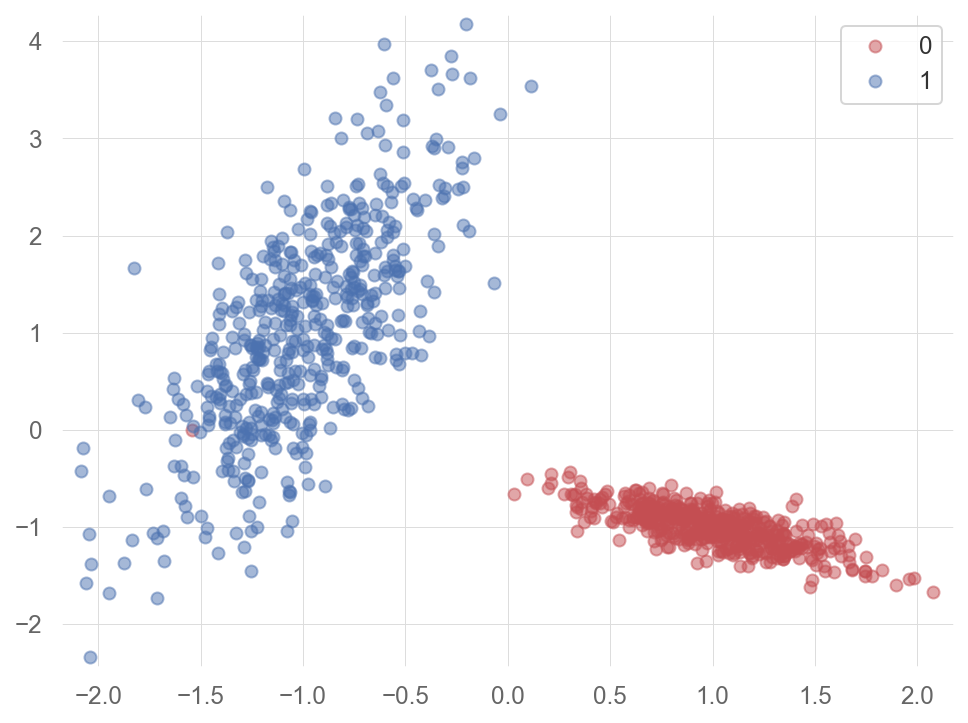

In [25]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           n_informative=2, random_state=7, n_clusters_per_class=1)
plot_data(X, y)


There is a LogisticRegression classifier available in scikit-learn, I won't go into too much detail here since our goal is to learn building models with Keras. But here's how to train an LR model, using the fit function just like any other model in scikit-learn. We see the linear decision boundary as the green line.

LR coefficients: [[-4.09049818  2.07274152]]
LR intercept: [-0.27800528]


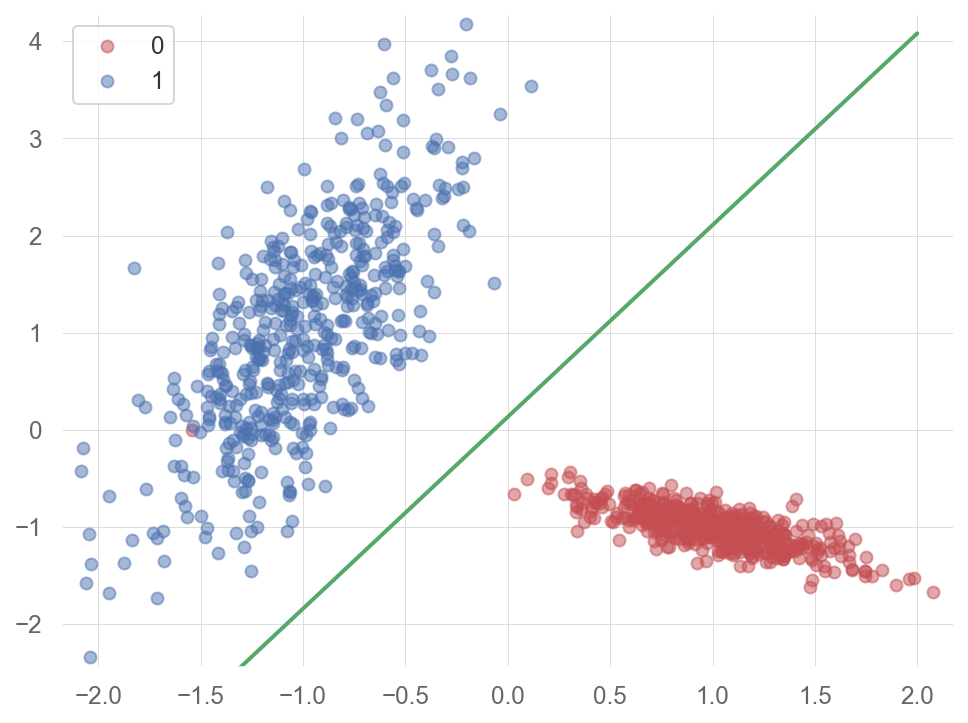

In [26]:
lr = sklearn.linear_model.LogisticRegression()
lr.fit(X, y)
print('LR coefficients:', lr.coef_)
print('LR intercept:', lr.intercept_)

plot_data(X, y)

limits = np.array([-2, 2])
boundary = -(lr.coef_[0][0] * limits + lr.intercept_[0]) / lr.coef_[0][1]
plt.plot(limits, boundary, "g-", linewidth=2)

We will use the Sequential model API available here. The Sequential model allows us to build deep neural networks, by stacking layers one top of another. Since we're now building a simple logistic regression model, we will have the input nodes directly connected to output node, without any hidden layers. 

The output of the fit method is the loss and accuracy at every epoch. We then plot it to see that the loss goes down to almost 0 over time, and the accuracy goes up to almost 1. 

<Figure size 576x432 with 0 Axes>

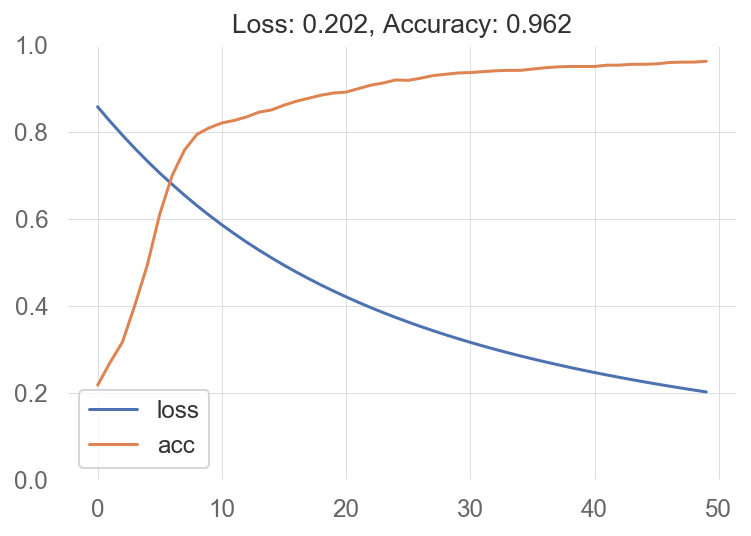

In [27]:
model = keras.Sequential()
model.add(Dense(units=1, input_shape=(2,), activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X, y=y, verbose=0, epochs=50)
plot_loss_accuracy(history)

A fancy plot of the decision boundary. The various shades of blue and red represent the probability of a hypothetical point in that area belonging to class 1. The top left area is classified as class 1, so the dark blue. The bottom right area is classified as class 0, so the dark red. And there is a transition around the decision boundary. I think this is a cool way to visualize the separator function the model is learning.

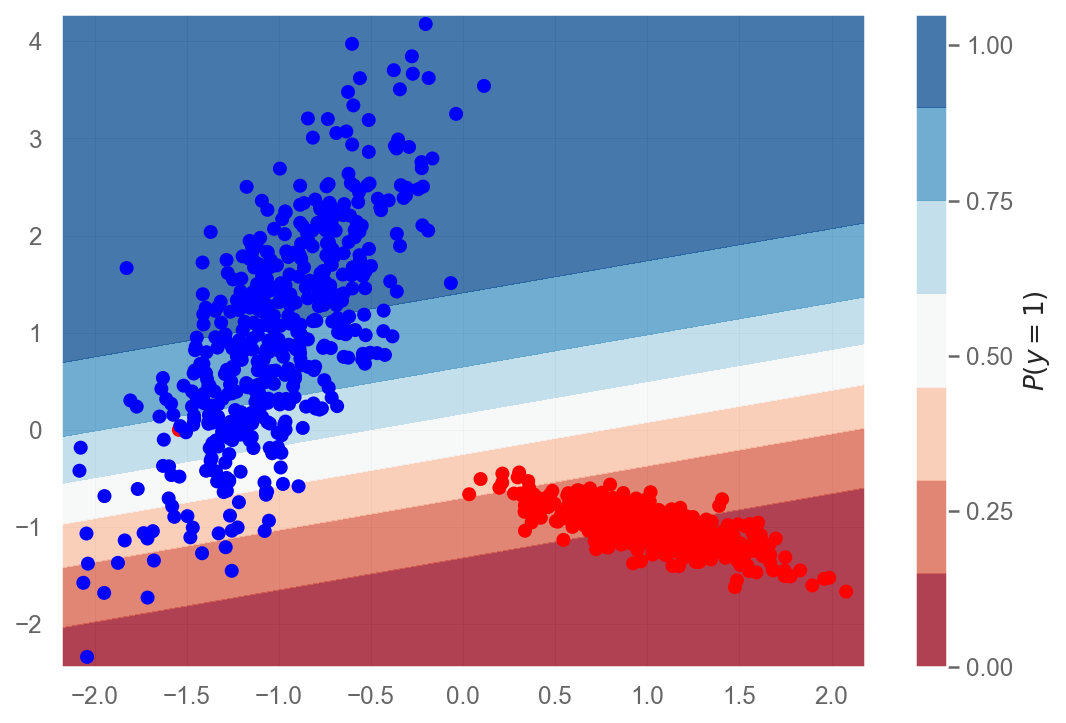

In [29]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

The classification report showing the precision and recall of our model.

In [30]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))

precision    recall  f1-score   support

           0       0.93      1.00      0.96       501
           1       1.00      0.93      0.96       499

    accuracy                           0.96      1000
   macro avg       0.97      0.96      0.96      1000
weighted avg       0.97      0.96      0.96      1000



The confusion matrix shows us how many classes were correctly classified vs misclassified. The numbers on the diagonal axis represent the number of correctly classified points, the rest are the misclassified ones. This particular matrix is not very interesting because the model correctly predicts the class of all but one point. We can see the misclassified point at the top right part of the confusion matrix, true value is class 0 but the predicted value is class 1.

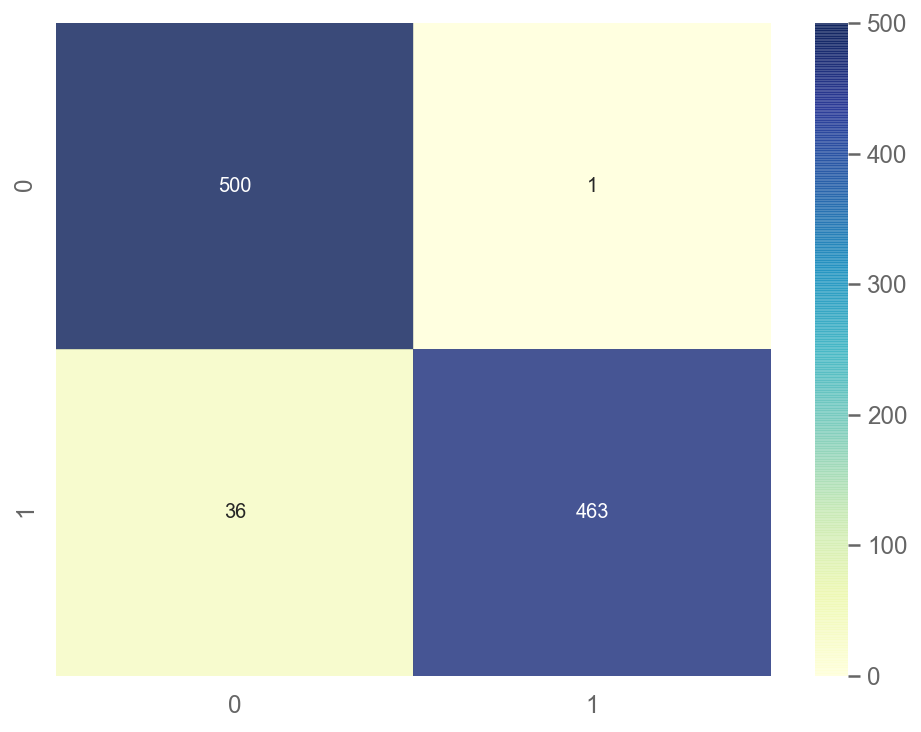

In [32]:

plot_confusion_matrix(model, X, y)

## Complex Data - Moons

The previous dataset was linearly separable, so it was trivial for our logistic regression model to separate the classes. Here is a more complex dataset which isn't linearly separable. The simple logistic regression model won't be able to distinguish between the classes.

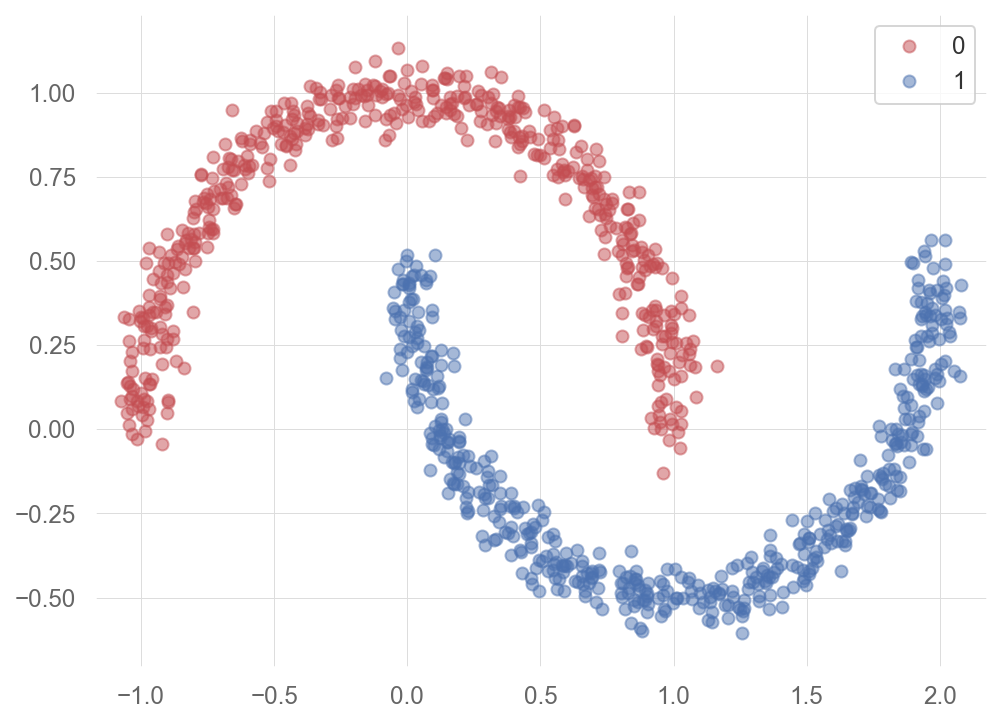

In [33]:

X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)
plot_data(X, y)

We're building the another logistic regression model with the same parameters as we did before.

<Figure size 576x432 with 0 Axes>

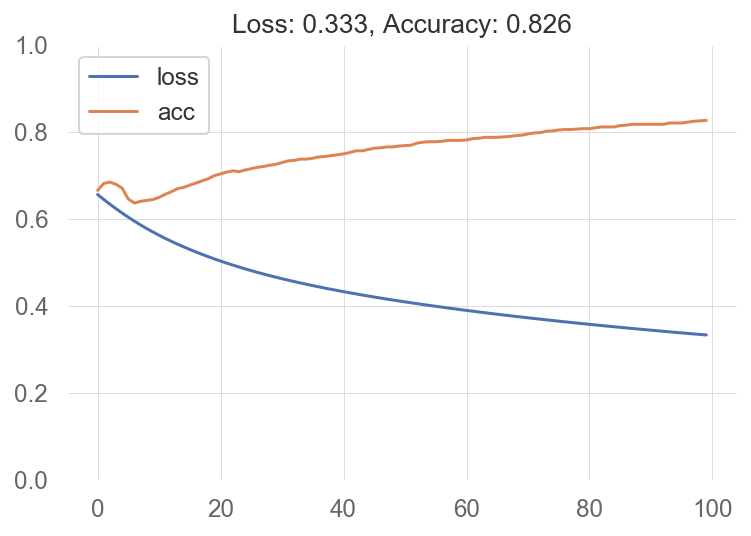

In [34]:

model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)

The current decision boundary doesn't look as clean as the one before. The model tried to separate out the classes from the middle, but there are a lot of misclassified points. We need a more complex classifier with a non-linear decision boundary, and we will see an example of that soon.

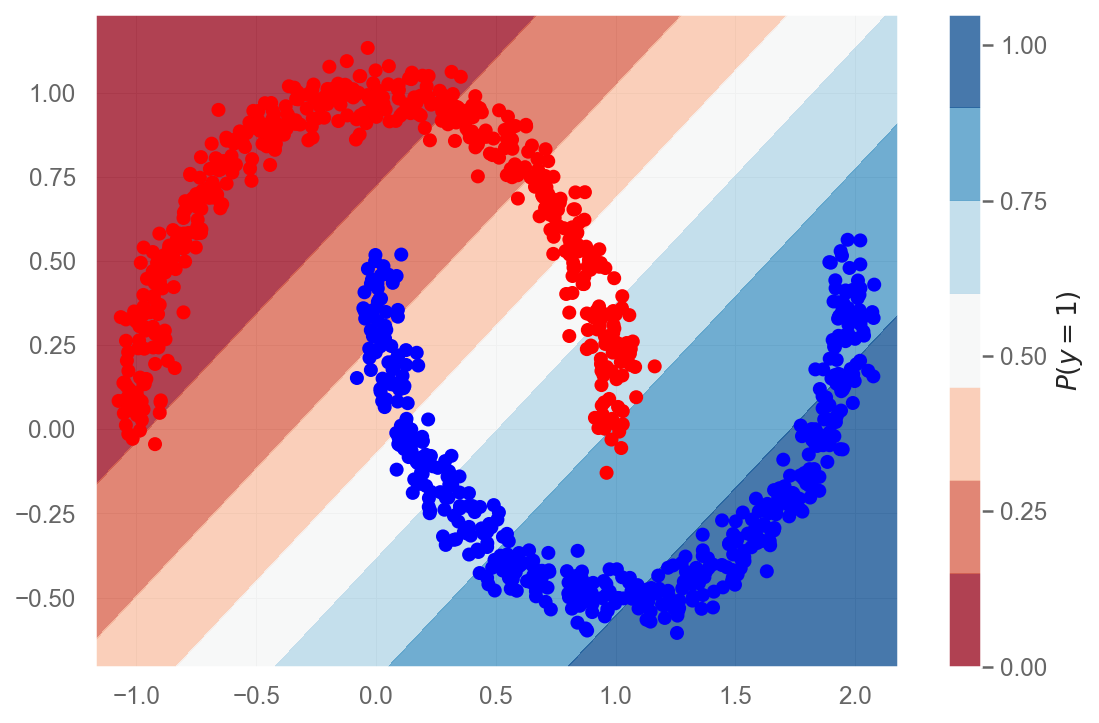

In [35]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

### More inner layers are needed

Complex Data - Circles
Let's look at one final example where the liner model will fail.

As you can see we first add a layer with 4 nodes and tanh activation function. Tanh is a commonly used activation function, and we'll learn more about it in another tutorial. We then add another layer with 2 nodes and again tanh activation. We finally add the last layer with 1 node and sigmoid activation. This is the final layer that we also used in the logistic regression model.

This is not a very deep ANN, it only has 3 layers: input layer, 1 hidden layer, and the output layer. But notice a couple of patterns:

Output layer still uses the sigmoid activation function since we're working on a binary classification problem.
Non-output layers use the tanh activation function. If we added more hidden layers, they would also have tanh activation.
We have fewer number of nodes in each subsequent layer. It's common to have less nodes as we stack layers on top of one another.
We didn't build a very deep ANN here because it wasn't necessary. We already achieve perfect accuracy with this configuration.

<Figure size 576x432 with 0 Axes>

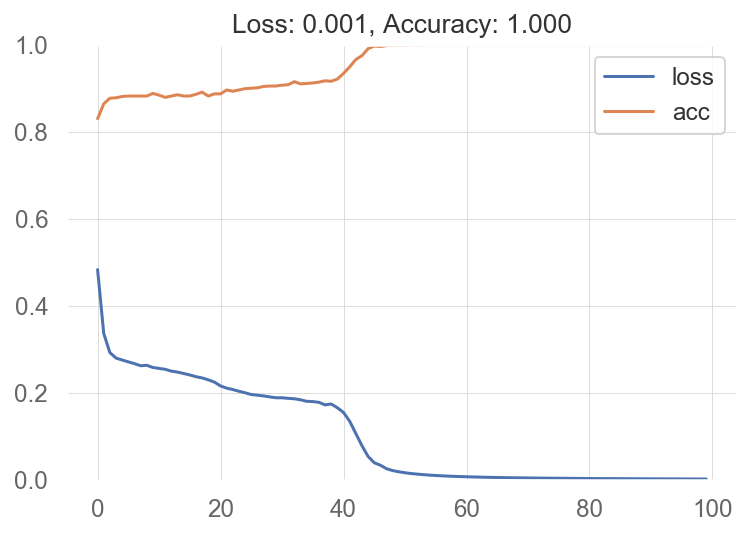

In [40]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)

model = keras.models.Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=100)

plot_loss_accuracy(history)

The ANN is able to come up with a perfect separator to distinguish the classes.

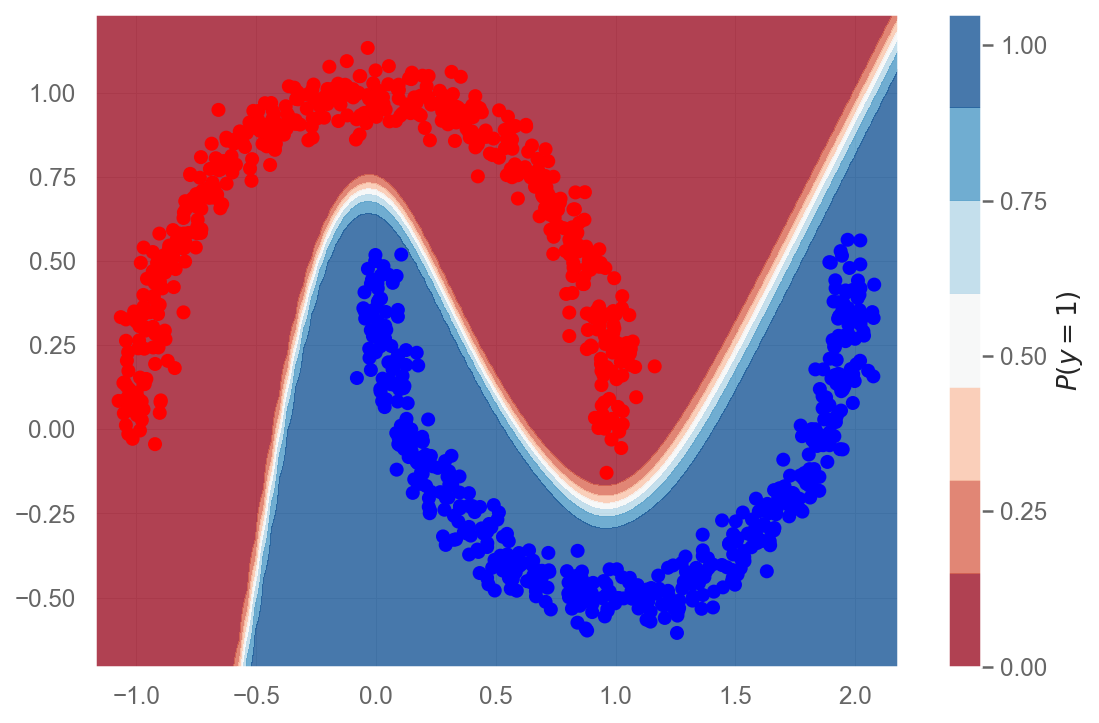

In [42]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

100% precision, nothing misclassified.

precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



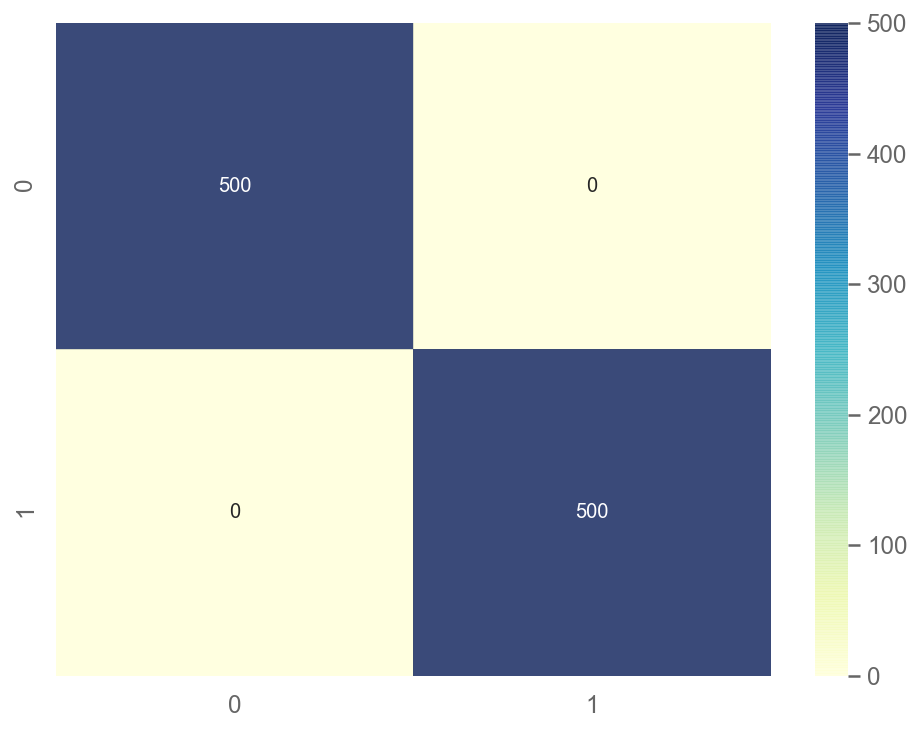

In [44]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## Complex Data - Circles

Let's look at one final example where the liner model will fail.


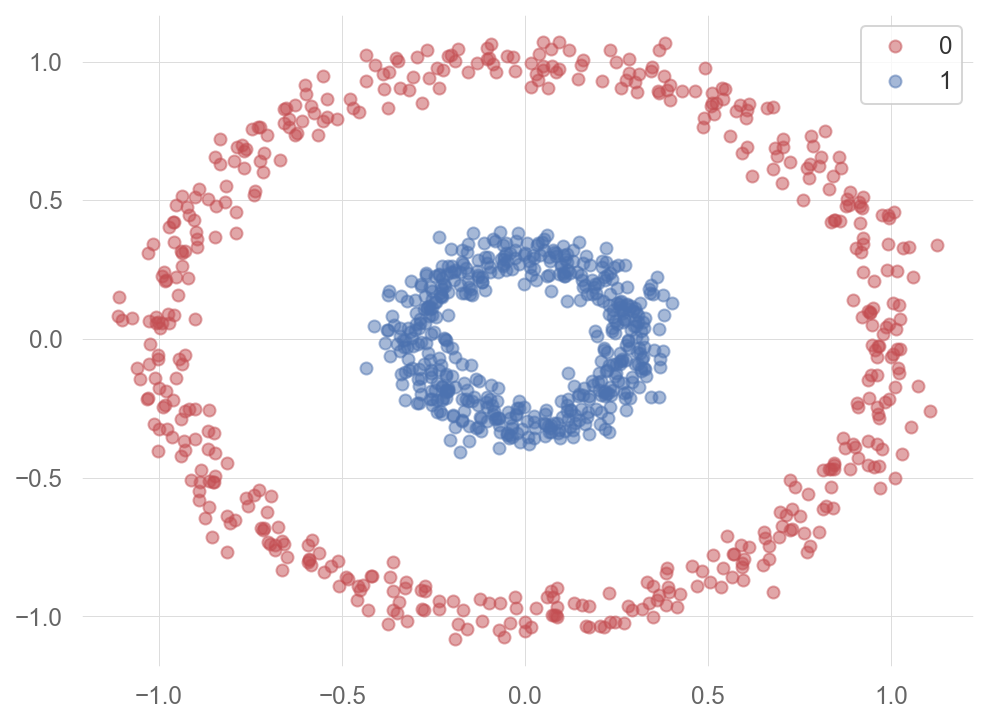

In [36]:

X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)
plot_data(X, y)

The model is the same as above, we only change the input to the fit function. And we again achieve 100% accuracy.

<Figure size 576x432 with 0 Axes>

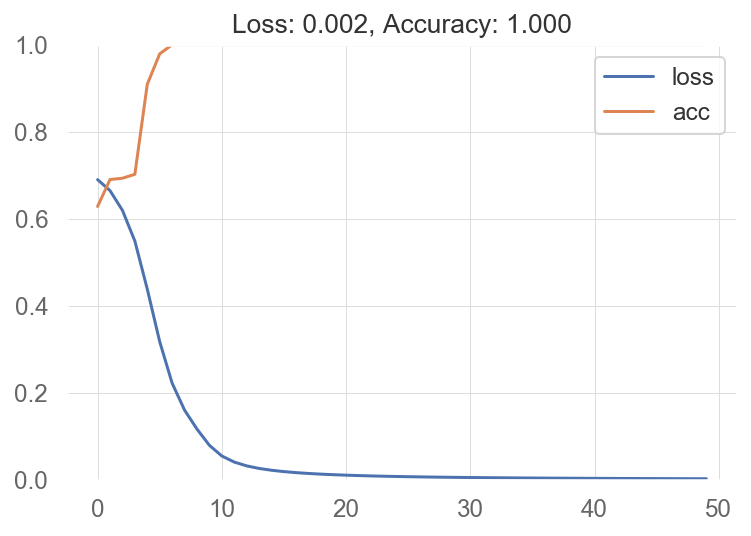

In [46]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)

model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)


Similarly the decision boundary looks just like one we would draw by hand ourselves. The ANN was able to figure out an optimal separator.

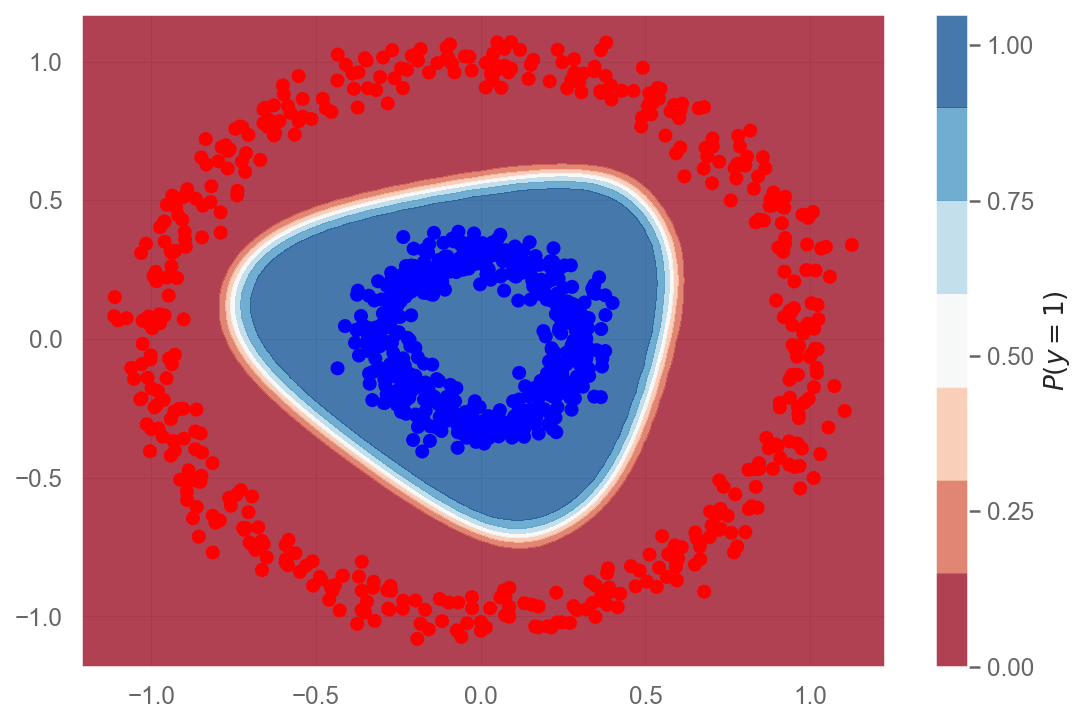

In [47]:
plot_decision_boundary(lambda x: model.predict(x), X, y)

precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



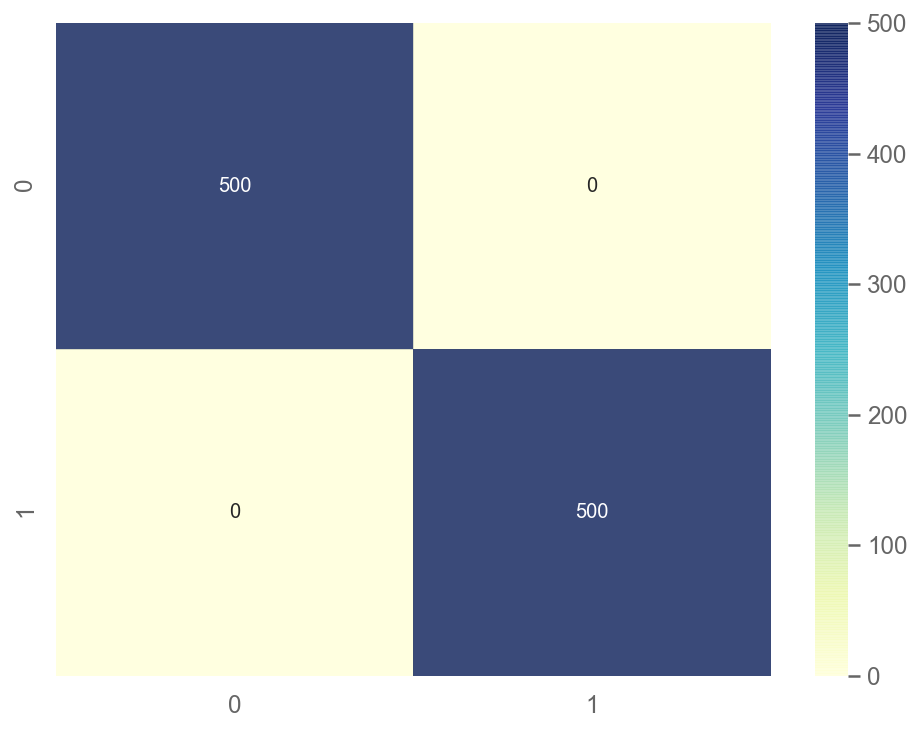

In [48]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## Complex Data - Sine Wave

Let's try to classify one final toy dataset, and then we will move on to real-world examples. In the previous sections, the classes were separable by one continuous decision boundary. The boundary had a complex shape, it wasn't linear, but still one decision boundary was enough. ANNs can draw arbitrary number of complex decision boundaries, and we will demonstrate that.

Let's create a sinusoidal dataset looking like the sine function, every up and down belongs to an alternating class. As we can see in the figure, a single decision boundary won't be able to separate out the classes. We will need a series of non-linear boundaries.

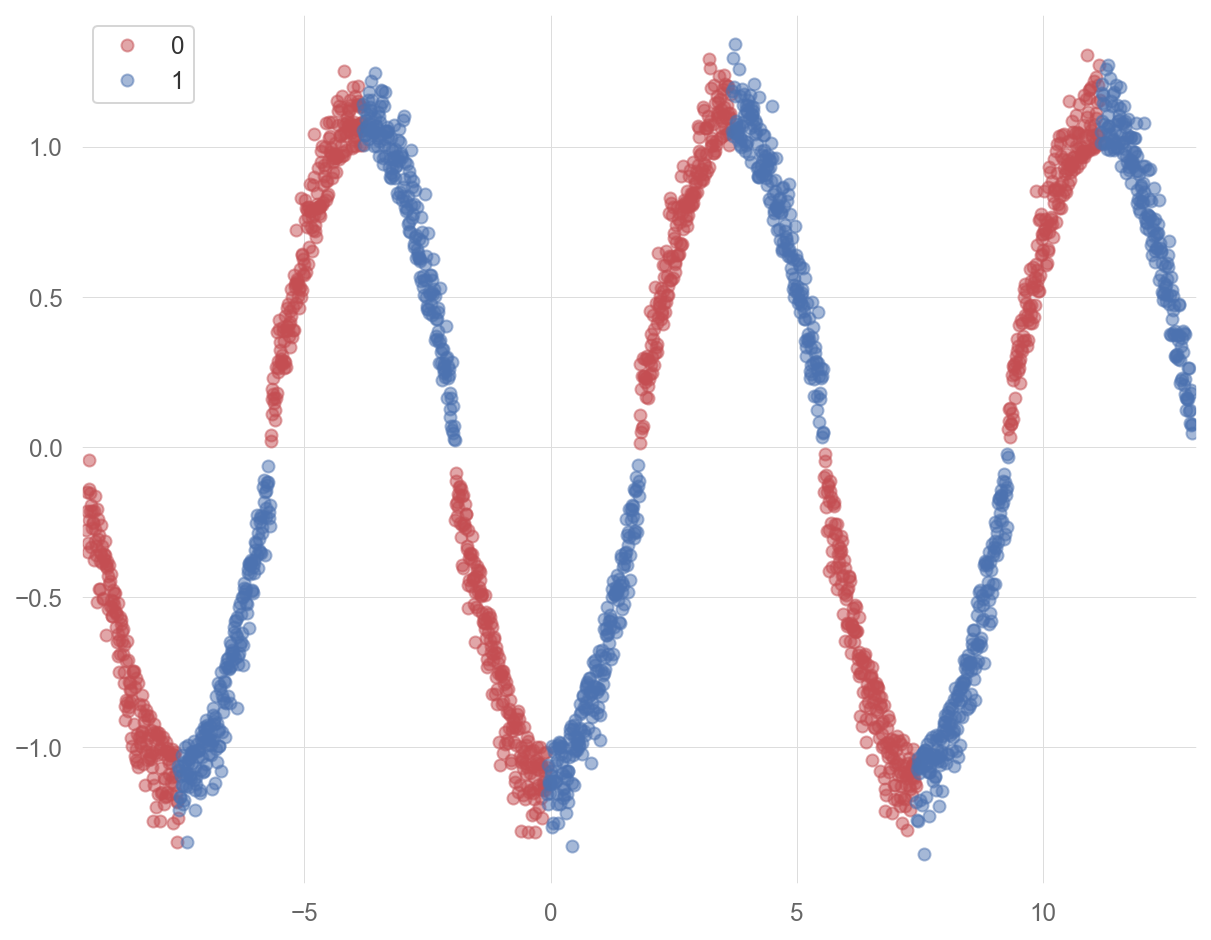

In [78]:
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2) for i in range(len(x0))])
    return X, y

X, y = make_sine_wave()

plot_data(X, y, figsize=(10, 8))


Now we need a more complex model for accurate classification. So we have an input layer, 2 hidden layers, and an output layer. The number of nodes per layer has also increased to improve the learning capacity of the model. Choosing the right number of hidden layers and nodes per layer is more of an art than science, usually decided by trial and error.

<Figure size 576x432 with 0 Axes>

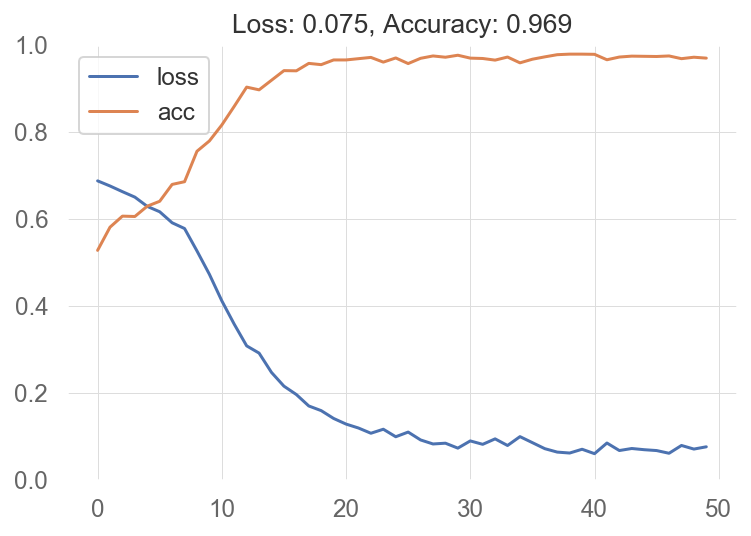

In [79]:
model = keras.models.Sequential()
model.add(Dense(64, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)

The ANN was able to model a pretty complex set of decision boundaries.

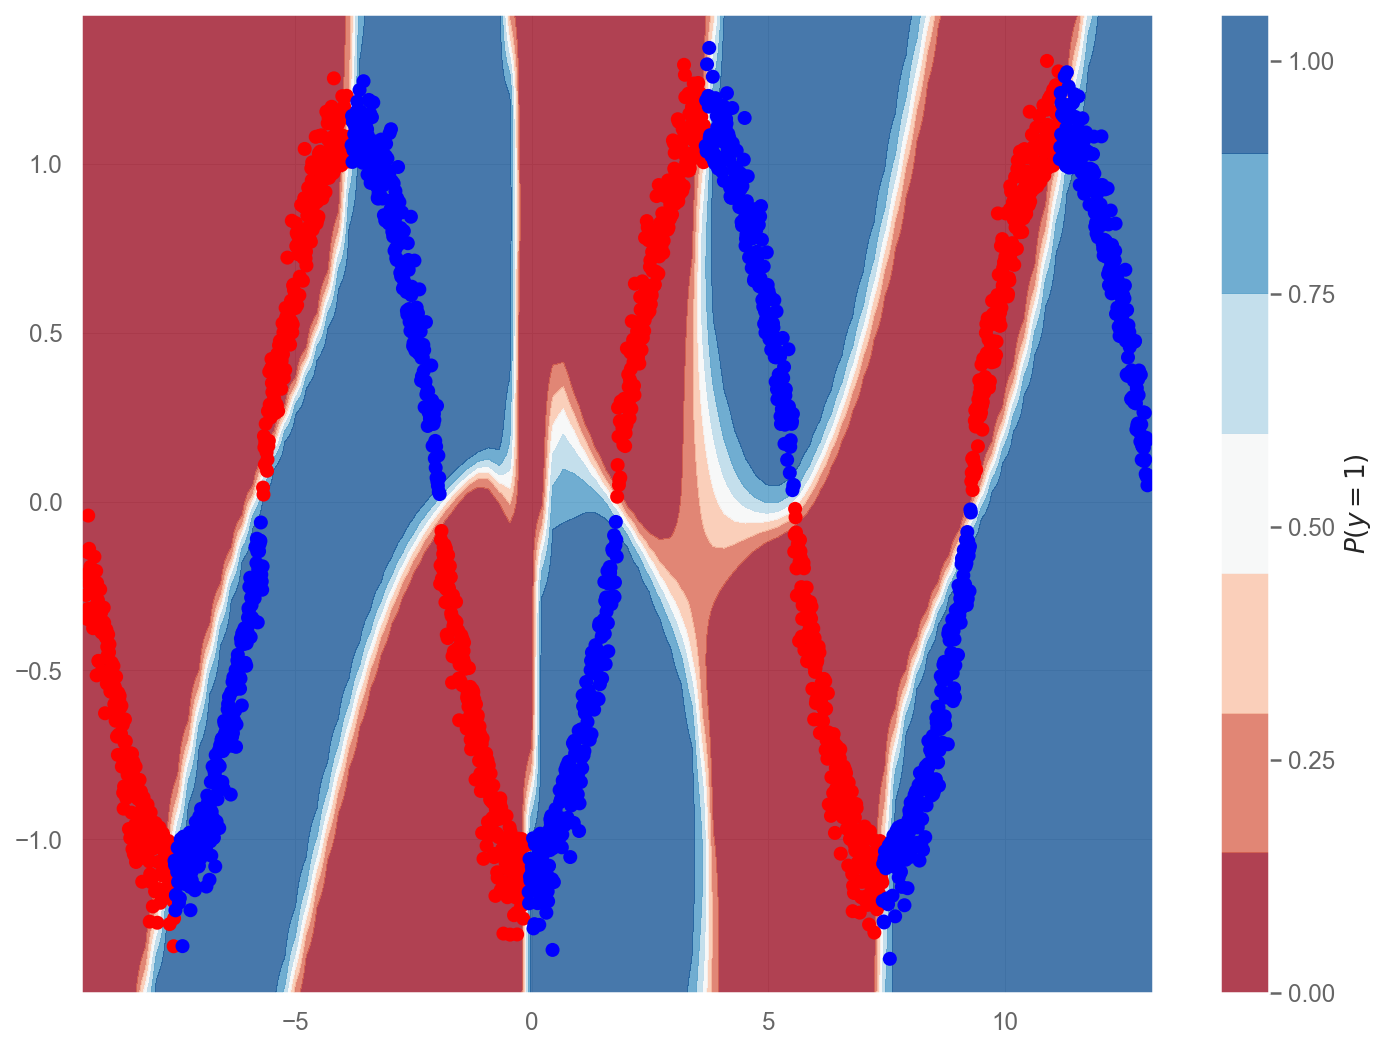

In [81]:
plot_decision_boundary(lambda x: model.predict(x), X, y, figsize=(12, 9))

precision    recall  f1-score   support

           0       0.98      0.98      0.98      1200
           1       0.98      0.98      0.98      1200

    accuracy                           0.98      2400
   macro avg       0.98      0.98      0.98      2400
weighted avg       0.98      0.98      0.98      2400



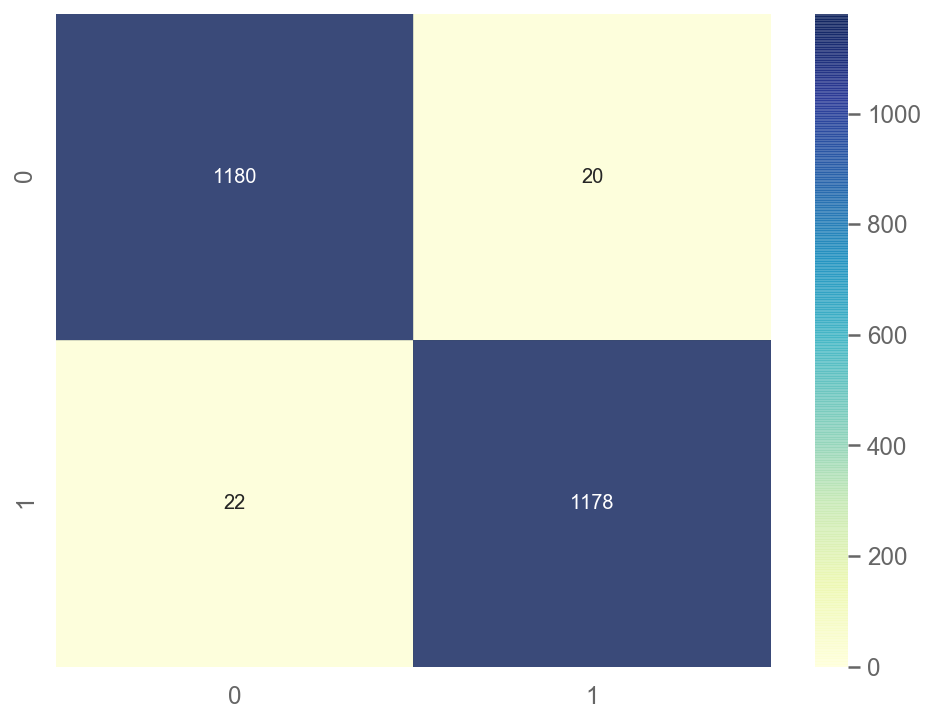

In [82]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)

## Multiclass Classification
In the previous sections we worked on a binary classification problem. Now we will take a look at a multi-class classification problem, where the number of classes is more than 2. We will pick 3 classes for demonstration, but our approach generalizes to any number of classes.

Here's how our dataset looks like, spiral data with 3 classes.

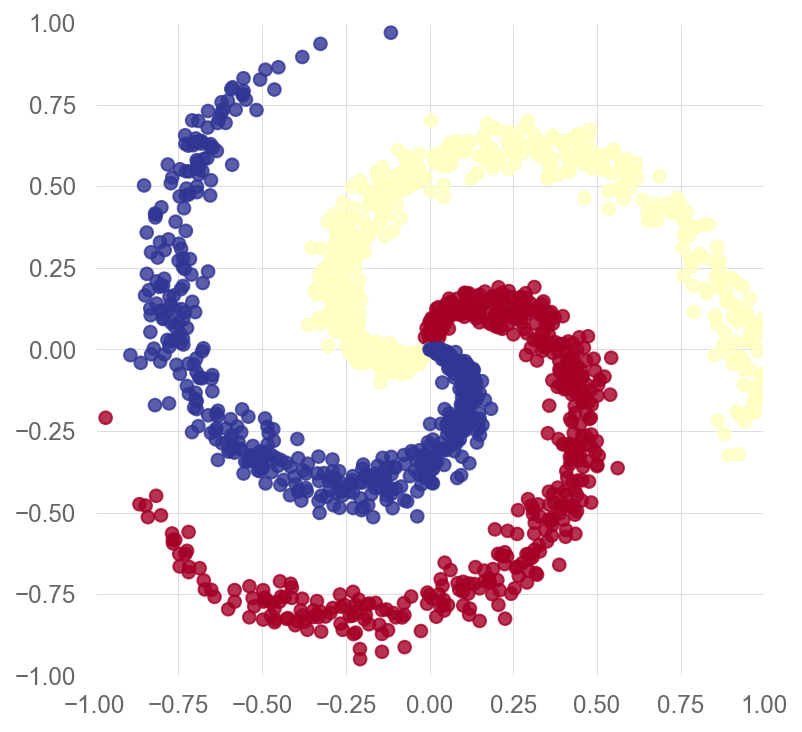

In [84]:
def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

X, y = make_multiclass(K=3)

### Softmax Regression
As we saw above, Logistic Regression (LR) is a classification method for 2 classes. It works with binary labels 0/1. Softmax Regression (SR) is a generalization of LR where we can have more than 2 classes. In our current dataset we have 3 classes, represented as 0/1/2.

Building the model for SR is very similar to LR, for reference here's how we built our Logistic Regression model.

```python
model = Sequential()
model.add(Dense(1, input_shape=(2,), activation='sigmoid'))

model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(X, y, verbose=0, epochs=20)
```

And here's how how we will build the Softmax Regression model. There are a couple of differences, let's go over them one by one:

• Number of node in the dense layer: LR uses 1 node, where SR has 3 nodes. Since we have 3 classes it makes sense for SR to have 3 nodes. Then the question is, why does LR uses only 1 node, it has 2 classes so it appears like we should have used 2 nodes instead. The answer is, because we can achieve the same result with using only 1 node. As we saw above, LR models the probability of an example belonging to class one: $P(class=1)$. And we can calculate class 0 probability by: $1 - P(class=1)$. But when we have more than 2 classes, we need individual nodes for each class. Because knowing the probability of one class doesn't let us infer the probability of the other classes.

• Activation function: LR used sigmoid activation function, SR uses softmax. It scales the probability of the output neurons such that they sum up to 1. So in our case $P(class=0) + P(class=1) + P(class=2) = 1$. It doesn't do it in a naive way by dividing individual probabilities by the sum though, it uses the exponential function. So higher values get emphasized more and lower values get squashed. We will talk in detail what softmax does in another tutorial. For now you can simply think of it as a normalization function which let's us interpret the output values as probabilities.

• Loss function: In a binary classification problem like LR, the loss function is binary_crossentropy. In the multiclass case like SR, the loss function is categorical_crossentropy. Going into the theory behind loss functions is beyond the scope of this tutorial. But for now only knowing this property is enough.

• Fit function: LR used the vector y directly in the fit function, which has just one column with binary 0/1 values. When we're doing SR the labels need to be in one-hot representation. In our case y_cat is a matrix with 3 columns, where all the values are 0 except for the one that represents our class, and that is 1.

<Figure size 576x432 with 0 Axes>

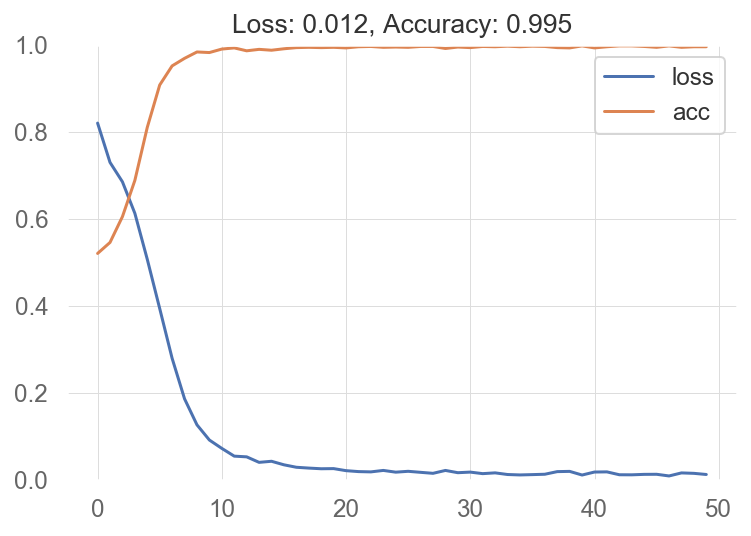

In [85]:
model = keras.models.Sequential()
model.add(Dense(128, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(3, activation='softmax'))

model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

y_cat = to_categorical(y)
history = model.fit(X, y_cat, verbose=0, epochs=50)
plot_loss_accuracy(history)

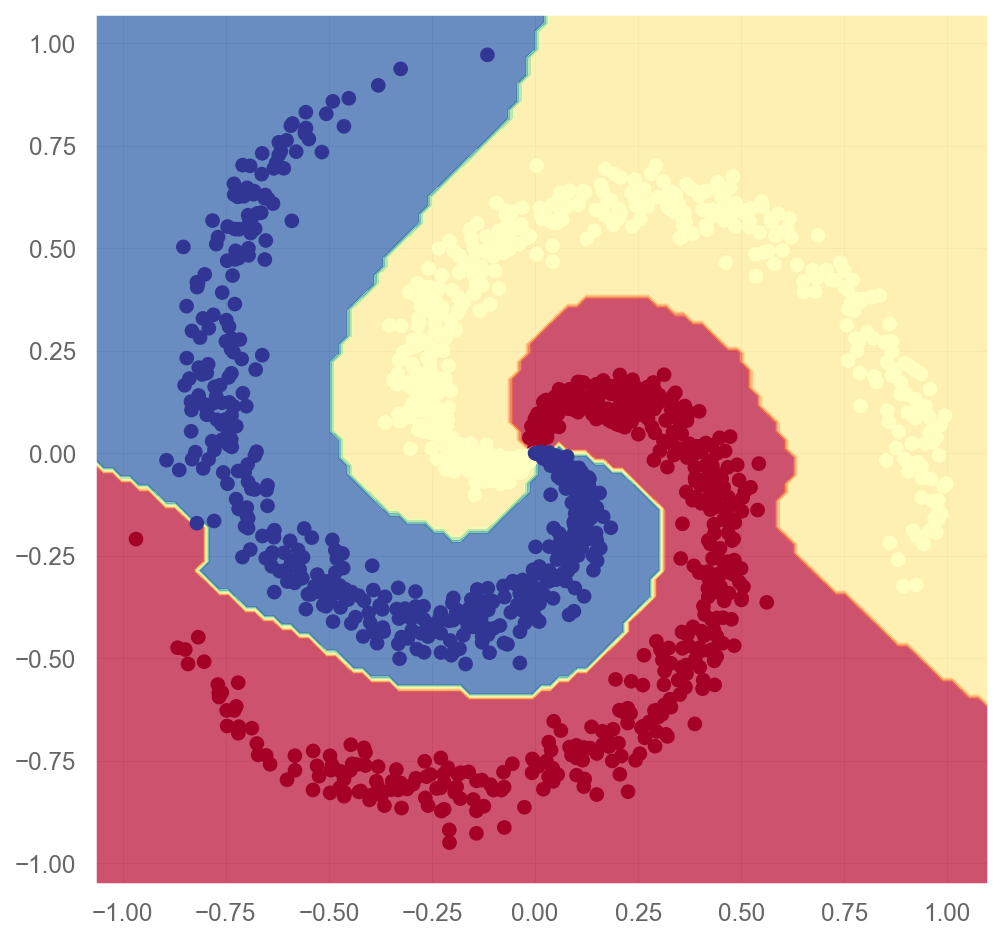

In [86]:
plot_multiclass_decision_boundary(model, X, y)

precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       500
         1.0       1.00      1.00      1.00       500
         2.0       1.00      0.99      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



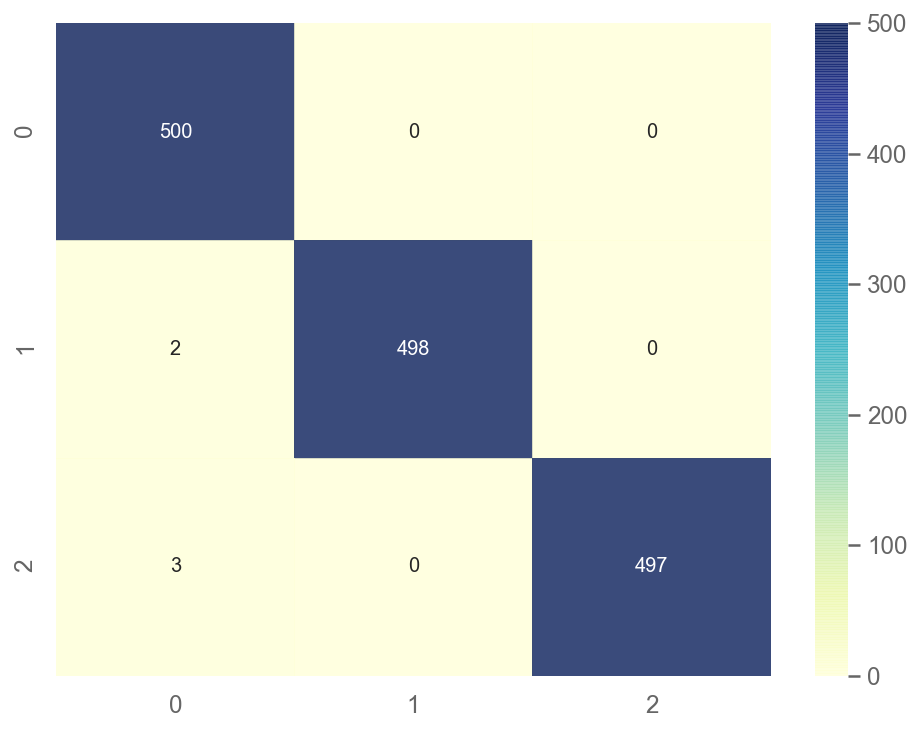

In [87]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))
plot_confusion_matrix(model, X, y)